In [17]:
# First lets explore the data some.
target.groupby(['surface']).agg(['count'])

,series_id,group_id
,count,count
surface,,
carpet,189,189
concrete,779,779
fine_concrete,363,363
hard_tiles,21,21
hard_tiles_large_space,308,308
soft_pvc,732,732
soft_tiles,297,297
tiled,514,514


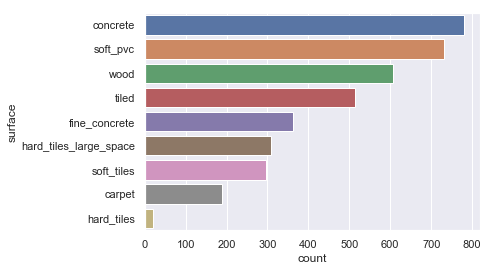

In [19]:
# Wow! The data is all over the place! There are a total of 73 groups with wildly different amounts of series in each group.
# Next lets look at some graphs of the data.

sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()


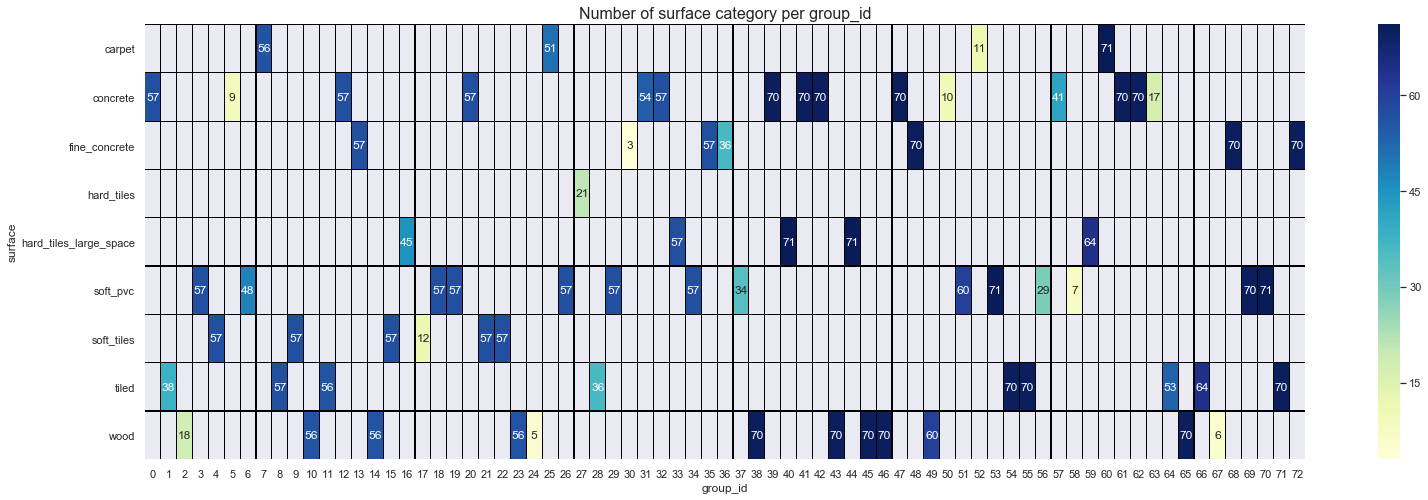

In [20]:
fig, ax = plt.subplots(1,1,figsize=(26,8))
tmp = pd.DataFrame(target.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

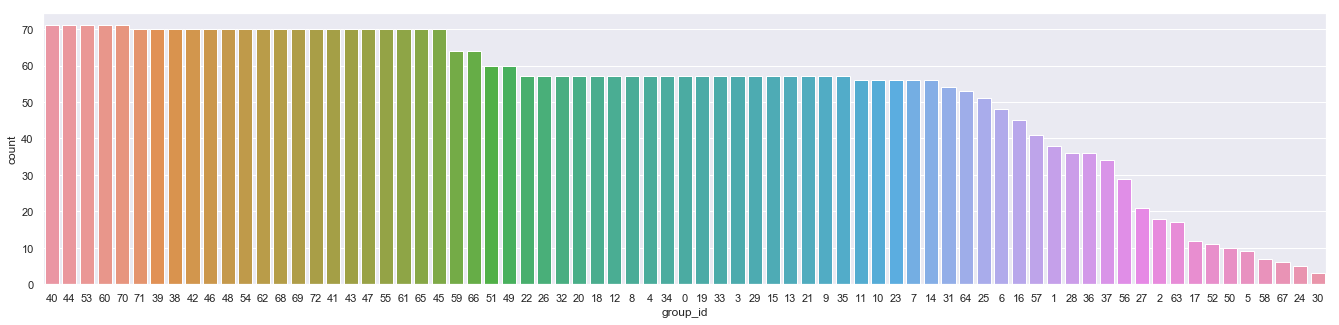

In [21]:
plt.figure(figsize=(23,5)) 
sns.set(style="darkgrid")
sns.countplot(x="group_id", data=target, order = target['group_id'].value_counts().index)
plt.show()

Carpet


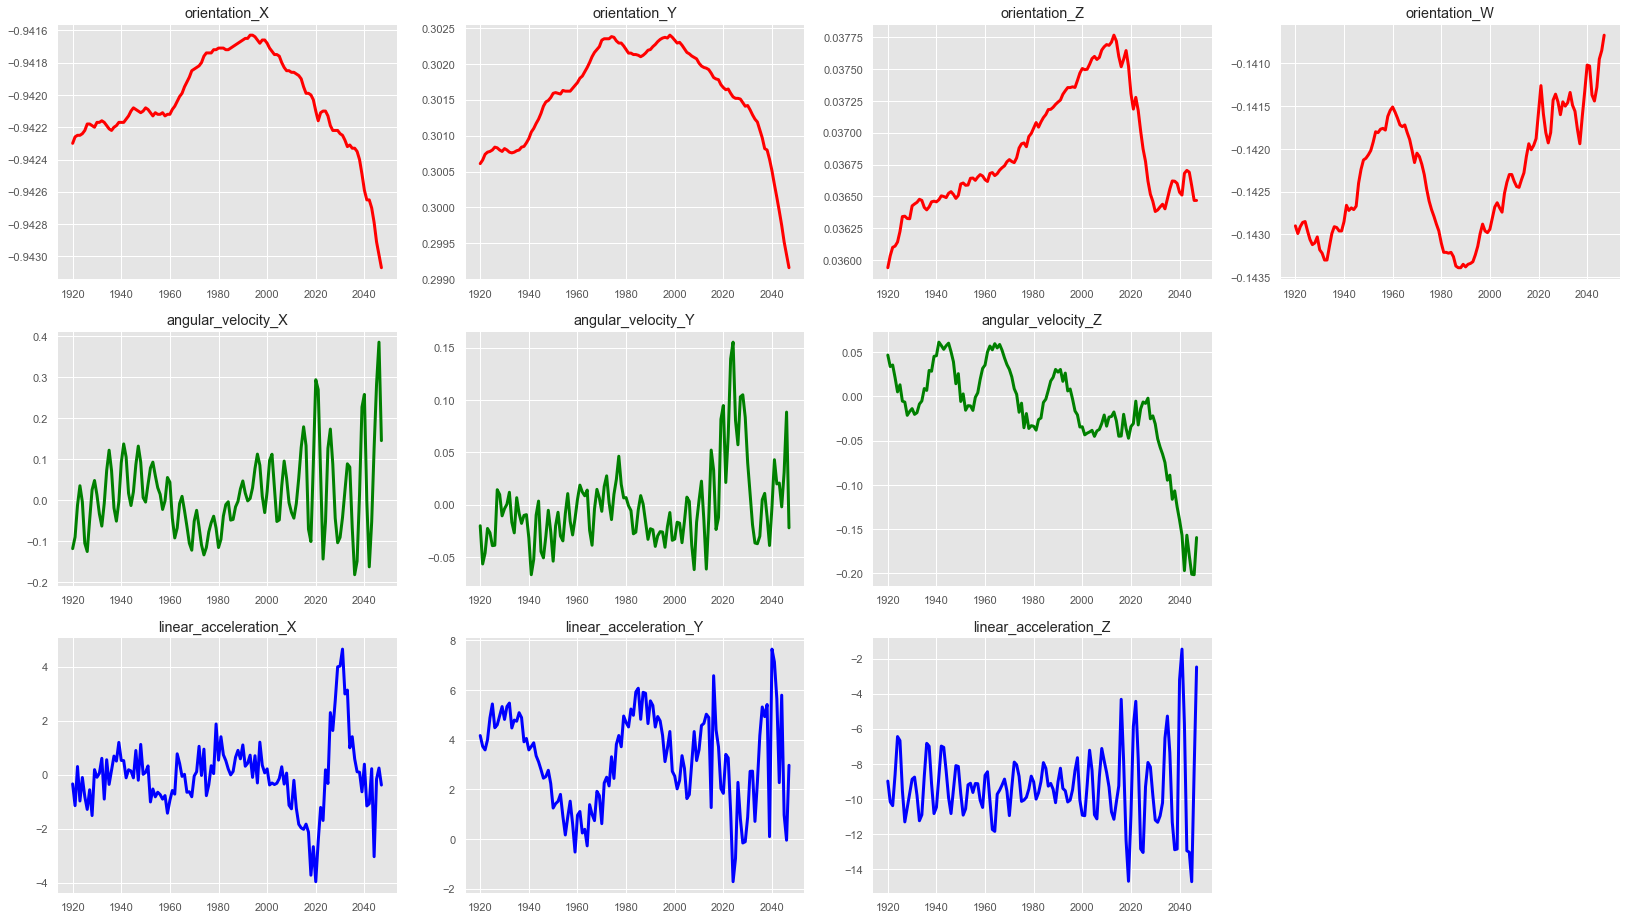

In [23]:
# Now you can choose which series measurement you want to visualize by changing the variable 'id_series' below.
id_series = 15
plotSeries(id_series)

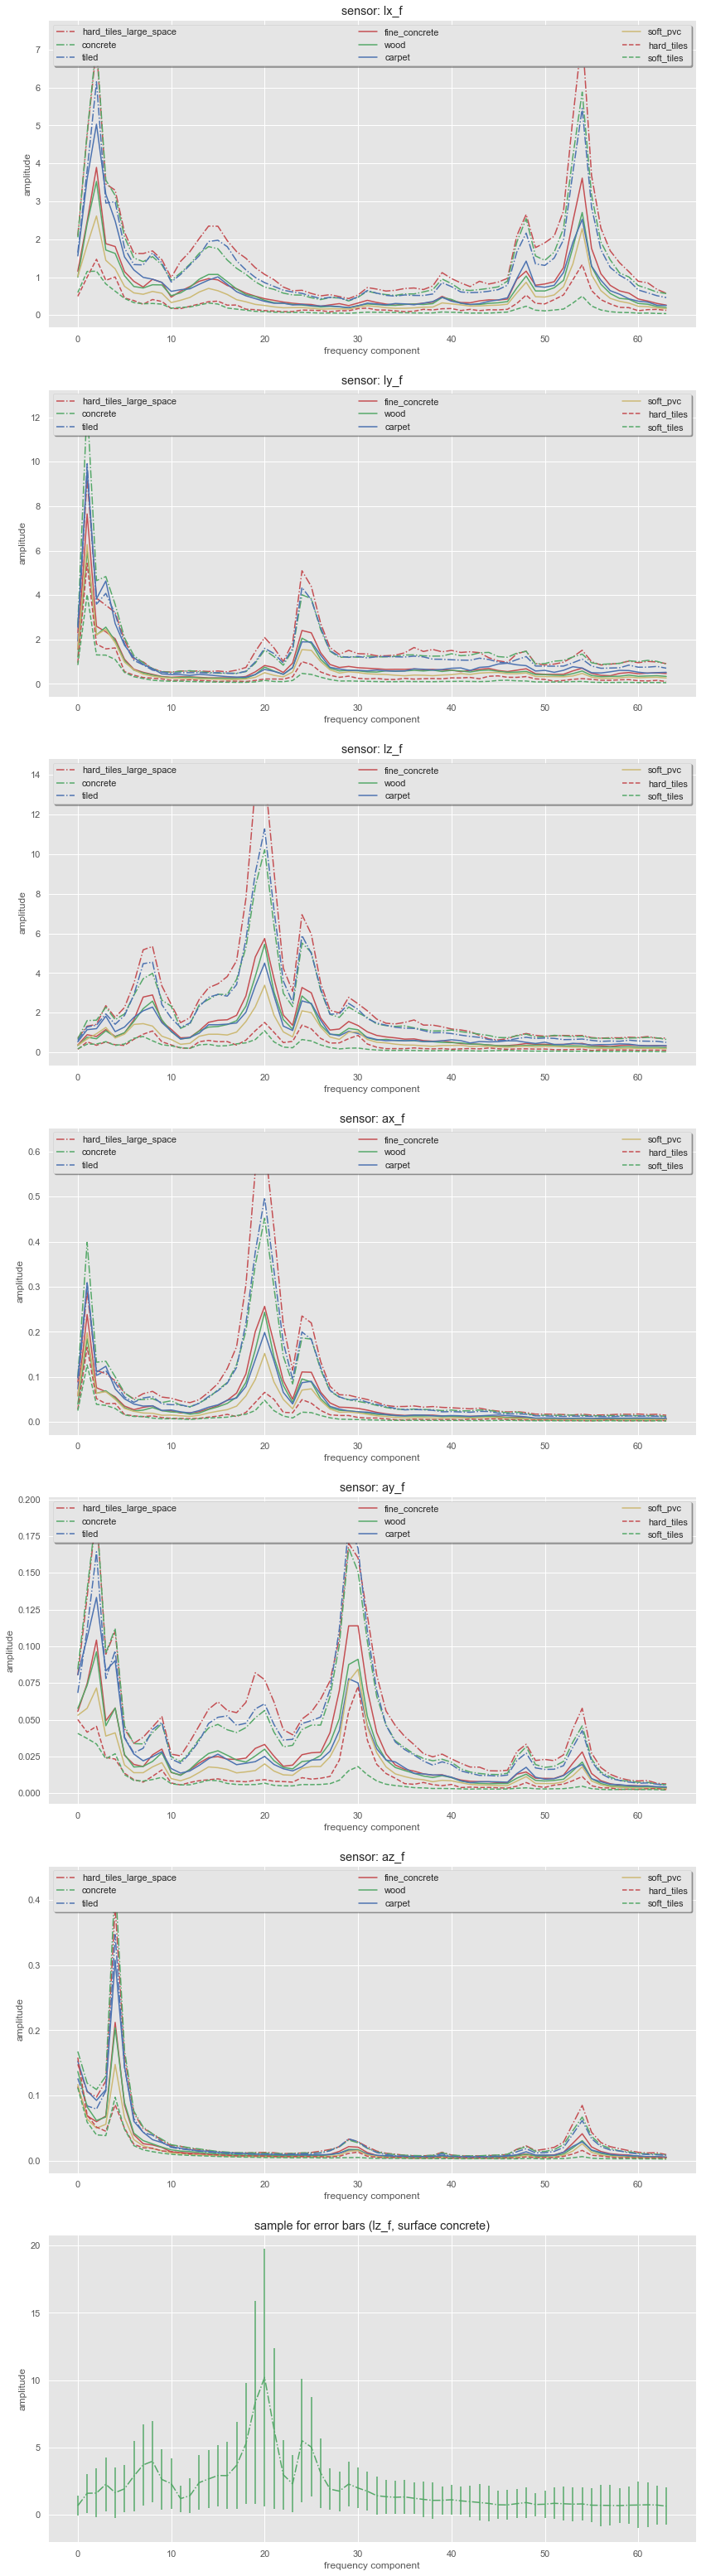

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8*7))

features=['lx_f','ly_f','lz_f','ax_f','ay_f','az_f']
count=0

for feature in features:
    stat= t.groupby('y').apply(aggf,feature)
    stat.index= stat.index.droplevel(-1)
    b=[*range(len(stat.at['carpet','mean']))]

    count+=1
    plt.subplot(len(features)+1,1,count)
    for i,(k,v) in enumerate(display.items()):
        plt.plot(b, stat.at[k,'mean'], v, label=k)
        # plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
   
    leg = plt.legend(loc='best', ncol=3, mode="expand", shadow=True, fancybox=True)
    plt.title("sensor: " + feature)
    plt.xlabel("frequency component")
    plt.ylabel("amplitude")

count+=1
plt.subplot(len(features)+1,1,count)
k='concrete'
v=display[k]
feature='lz_f'
stat= t.groupby('y').apply(aggf,feature)
stat.index= stat.index.droplevel(-1)
b=[*range(len(stat.at['carpet','mean']))]

plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
plt.title("sample for error bars (lz_f, surface concrete)")
plt.xlabel("frequency component")
plt.ylabel("amplitude")

plt.show()

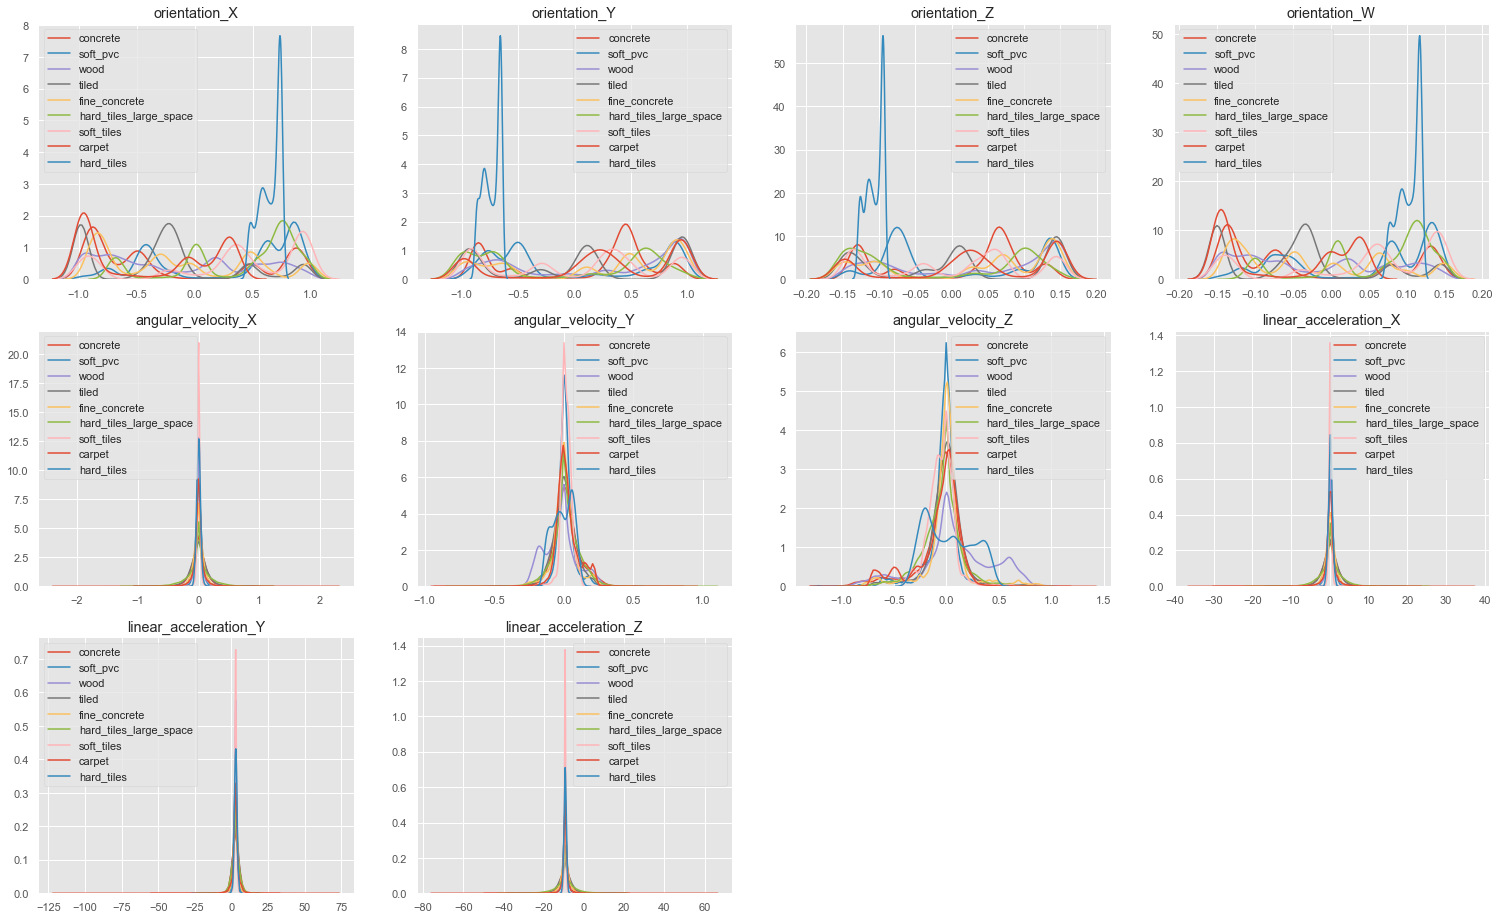

In [31]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(aux.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

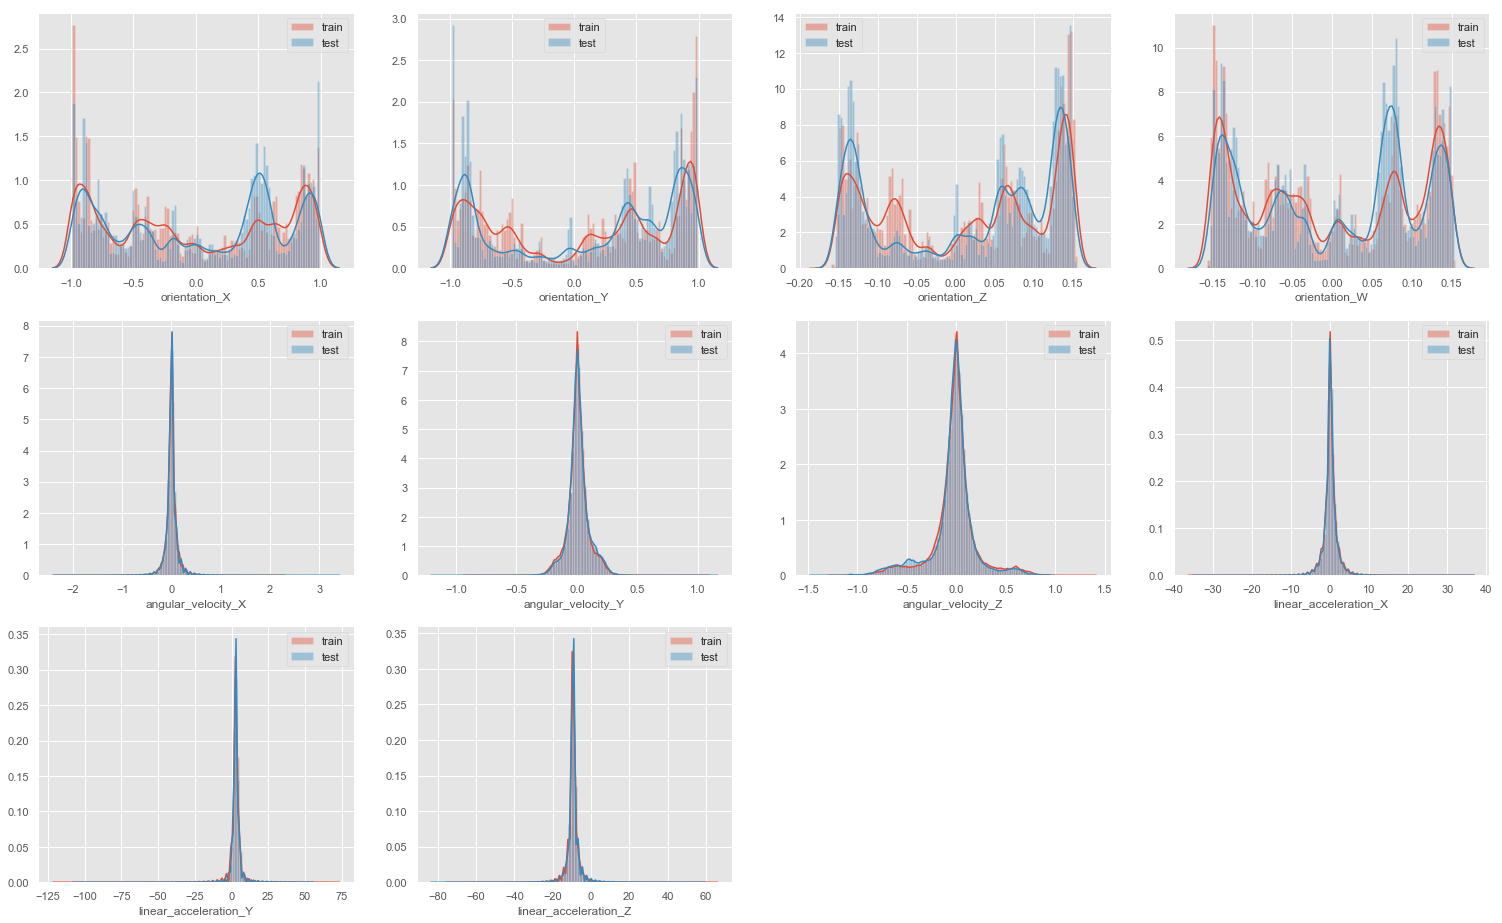

In [32]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(data.columns[3:]):
    ax = plt.subplot(3, 4, i + 1)
    sns.distplot(data[col], bins=100, label='train')
    sns.distplot(test[col], bins=100, label='test')
    ax.legend() 

In [33]:
# First we will convert the quaterion to euler angles to give the model more to work with.
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [37]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [20]:
data = np.array([[1,2],[3,4],[5,6]])

In [67]:
def environment(data):

    s = []
    m = []
    z = []
    b1 = []
    b2 = []
    b3 = []

    for n in data:
        st = np.array([n, np.zeros(len(n)), n])
        s.append(st)

    for n in np.array(s):
        b1t = n[0]
        b1.append(b1t)
        b2t = n[1]
        b2.append(b2t)
        b3t = n[2]
        b3.append(b3t)


    def action(b1):

        #temp policy creation tool.
        policy = []

        for i in range(len(b1)):
            if np.random.random() > .5:
                policy.append('remove')
            else:
                policy.append('copy')

        return policy


#         for i in b1:
#             policy = PPO(b1[i])

    def reward_function(s):

        r = []
        b1 = s[0]
        b2 = s[1]
        b3 = s[2]
        z = s[3]
        m = s[4]
        
        i = 0
        
        for i in range(1):
            
            for t in b1:

                zt = np.concatenate((b2[i], b3[i]), axis=0)
                mt = t.size
                m.append(mt)
                z.append(np.count_nonzero(zt))
                
#                 r = 1-2*m/z
        
        for t in range(len(b1)):
            rt = 1 - (z[t]/m[t])
            r.append(rt)

        return r


    def update(policy, b1, b2, b3):

        i = 0

        for i in range(len(policy)):
            
            for t in policy:
                if policy[i] == 'copy':
                    b2[i] = b1[i]
                if policy[i] == 'remove':
                    b3[i] = np.zeros(len(b1[i]))
                    
                zt = np.concatenate((b2[i], b3[i]), axis=0)
                z.append((np.count_nonzero(zt==0)))
                mt = np.array(b1[i]).size
                m.append(mt)

                i += 1

            return b1, b2, b3, z, m

    return reward_function(update(action(b1), b1, b2, b3))

In [93]:
environment(data)

[-1.0, -1.0, 1.0]

In [ ]:
def modified_z_score(intensity):
    median_int = np.median(intensity)
    mad_int = np.median([np.abs(intensity - median_int)])
    if mad_int == 0:
        mad_int = 1
    modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
    return modified_z_scores


def df_fixer(y,n):
    
    threshold = 0
    x = 0
    while threshold == 0:
        
        if np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) > 150:
            
            if abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+55:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+55:

                x += 5
                
                
        elif np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) <= 150:
                
            if abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+55:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+55:

                x += 5

    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy()

    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            
            y_out[i+y_out.index[0]] = None
    return y_out

def spike_finder(y,n):
    
    threshold = 0
    x = 0
    while threshold == 0:
        
        if np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) > 150:
            
            if abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+55:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+55:

                x += 5
                
                
        elif np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) <= 150:
                
            if abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+55:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(data.Qonset[n*12])+x:int(data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+55:

                x += 5

    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    if spikes[10:].any() == False:
        return 'Unpaced'
    
    elif np.where(spikes[int(data.Qonset[n*12])-100:int(data.Qoffset[n*12])]==True)[0].any():

        if len(np.where(spikes[int(data.Qonset[n*12])-100:int(data.Qoffset[n*12])]==True)[0]) > 1 and (np.where(spikes[int(data.Qonset[n*12])-150:int(data.Qoffset[n*12])]==True)[0][1::1] - np.where(spikes[int(data.Qonset[n*12])-150:int(data.Qoffset[n*12])]==True)[0][:-1:1]).max() > 5 and spikes[int(data.Ponset[n*12]-60):int(data.Poffset[n*12])-30].any():
            return 'Atrial and Bi-Ventricular Paced'

        elif spikes[int(data.Qonset[n*12])-100:int(data.Qoffset[n*12])].any() and spikes[int(data.Ponset[n*12]-60):int(data.Poffset[n*12])-30].any():
            return 'Atrial and Ventricular Paced'

        elif len(np.where(spikes[int(data.Qonset[n*12])-100:int(data.Qoffset[n*12])]==True)[0]) > 1 and (np.where(spikes[int(data.Qonset[n*12])-60:int(data.Qoffset[n*12])]==True)[0][1::1] - np.where(spikes[int(data.Qonset[n*12])-60:int(data.Qoffset[n*12])]==True)[0][:-1:1]).max() > 5:
            return 'Bi-Ventricular Paced'

        elif spikes[int(data.Qonset[n*12])-100:int(data.Qoffset[n*12])].any():
            return 'Ventricular Paced'

    elif spikes[int(data.Ponset[n*12]-60):int(data.Poffset[n*12])-30].any():
        return 'Atrial Paced'

    else:
        return 'Paced'

def half_df_fixer(y,n):
    
    threshold = 0
    x = 0
    while threshold == 0:
        
        if np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) > 150:
            
            if abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+60:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+60:

                x += 2
            
        elif np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) <= 150:  
            
            
            if abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+60:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+60:

                x += 2

    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            
            y_out[i+y_out.index[0]] = None
            
    return y_out

def half_spike_finder(y,n):
    
    threshold = 0
    x = 0
    while threshold == 0:
        
        if np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) > 150:
            
            if abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+60:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .98)+60:

                x += 2
            
        elif np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), 1) <= 150:  
            
            
            if abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() < np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+60:

                threshold = abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() + 1

            elif abs(np.array(modified_z_score(np.diff(y))))[int(half_data.Qonset[n*12])+x:int(half_data.Qoffset[n*12])+30].max() > np.nanquantile(abs(np.array(modified_z_score(np.diff(y)))), .992)+60:

                x += 2

    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    if spikes[10:].any() == False:
        return 'Unpaced'
    
    elif np.where(spikes[int(half_data.Qonset[n*12])-100:int(half_data.Qoffset[n*12])]==True)[0].any():

        if len(np.where(spikes[int(half_data.Qonset[n*12])-100:int(half_data.Qoffset[n*12])]==True)[0]) > 1 and (np.where(spikes[int(half_data.Qonset[n*12])-150:int(half_data.Qoffset[n*12])]==True)[0][1::1] - np.where(spikes[int(half_data.Qonset[n*12])-150:int(half_data.Qoffset[n*12])]==True)[0][:-1:1]).max() > 5 and spikes[int(half_data.Ponset[n*12]-60):int(half_data.Poffset[n*12])-30].any():
            return 'Atrial and Bi-Ventricular Paced'

        elif spikes[int(half_data.Qonset[n*12])-100:int(half_data.Qoffset[n*12])].any() and spikes[int(half_data.Ponset[n*12]-60):int(half_data.Poffset[n*12])-30].any():
            return 'Atrial and Ventricular Paced'

        elif len(np.where(spikes[int(half_data.Qonset[n*12])-100:int(half_data.Qoffset[n*12])]==True)[0]) > 1 and (np.where(spikes[int(half_data.Qonset[n*12])-60:int(half_data.Qoffset[n*12])]==True)[0][1::1] - np.where(spikes[int(half_data.Qonset[n*12])-60:int(half_data.Qoffset[n*12])]==True)[0][:-1:1]).max() > 5:
            return 'Bi-Ventricular Paced'

        elif spikes[int(half_data.Qonset[n*12])-100:int(half_data.Qoffset[n*12])].any():
            return 'Ventricular Paced'

    elif spikes[int(half_data.Ponset[n*12]-60):int(half_data.Poffset[n*12])-30].any():
        return 'Atrial Paced'

    else:
        return 'Paced'


def hanging_line(point1, point2):

    a = (point2[1] - point1[1])/(np.cosh(point2[0] % 600) - np.cosh(point1[0] % 600))
    b = point1[1] - a*np.cosh(point1[0] % 600)
    x = np.linspace(point1[0], point2[0], (point2[0] - point1[0])+1)
    y = a*np.cosh(x % 600) + b

    return (x,y)

In [ ]:
Tags = {'tags':[]}
tags = {'tags':[]}
for root in roots:
    
    if len(root.find('{http://www3.medical.philips.com}waveforms').getchildren()) == 2:
    
        if int(root.find('{http://www3.medical.philips.com}waveforms')[1].attrib['samplespersec']) == 1000:

            for elem in root.find('{http://www3.medical.philips.com}waveforms')[1]:

                tag = {}

                tag['Lead'] = elem.attrib['leadname']
                if (root[6][1][0][14].text == 'Invalid' or elem[0].text == 'Invalid') and root[6].tag == '{http://www3.medical.philips.com}internalmeasurements':
                    if root[6][1][0][14].text == None or root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Invalid' or root[6][1][0][14].text == '\n        ' or root[6][1][0][14].text == 'Failed':
                        tag['Ponset'] = 0
                        tag['Pdur'] = 0
                        tag['Print'] = 0
                        tag['Poffset'] = 0
                    else:
                        tag['Ponset'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)
                        tag['Pdur'] = 0
                        tag['Print'] = int(root[6][1][0][14].text)
                        tag['Poffset'] = (int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)) + 0

                elif root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Invalid' or root[6][1][0][14].text == None or root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Failed' or root[6][1][0][14].text == 'Failed' or (root[6][1][0][14].text == 'Invalid' or elem[0].text == 'Invalid'):
                    tag['Ponset'] = 0
                    tag['Pdur'] = 0
                    tag['Print'] = 0
                    tag['Poffset'] = 0
                else:
                    tag['Ponset'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)
                    tag['Pdur'] = int(elem[0].text)
                    tag['Print'] = int(root[6][1][0][14].text)
                    tag['Poffset'] = (int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)) + int(elem[0].text)

                if (root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Invalid' or root[6][0][29].text == 'Invalid' or elem[4].text == 'Invalid' or root[6][1][0][18].text == 'Invalid'):
                    tag['Qonset'] = np.nan
                    tag['Qrsdur'] = np.nan
                    tag['Qoffset'] = np.nan
                    tag['Tonset'] = np.nan
                    tag['Qtint'] = np.nan
                    tag['Toffset'] = np.nan
                    tag['Tdur'] = np.nan
                else:
                    tag['Qonset'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text)
                    tag['Qrsdur'] = int(root[6][0][29].text)
                    tag['Qoffset'] =  tag['Qonset'] +  tag['Qrsdur']
                    tag['Tonset'] = int(elem[4].text)
                    tag['Qtint'] = int(root[6][1][0][18].text)
                    tag['Toffset'] =  tag['Qonset'] + tag['Qtint']
                    tag['Tdur'] = tag['Qoffset'] - tag['Qonset']

                if root[7].tag == '{http://www3.medical.philips.com}interpretations' and root[6].tag == '{http://www3.medical.philips.com}internalmeasurements':
                    if root[7][0][1][0].text != None and (root[7][0][1][0].text).isdigit(): tag['HeartRate'] = int(root[7][0][1][0].text)
                    if root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[1].text != None: tag['RRint'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[1].text)
                    if root[6][1][0][9].text != None: tag['AtrialRate'] = int(root[6][1][0][9].text)
                    if root[6][0][15].text != None and root[6][0][15].text != 'Indeterminate': tag['QRSFrontAxis'] = int(root[6][0][15].text)
                    if root[6][0][31].text != None and root[6][0][31].text != 'Failed': tag['QTC'] = int(root[6][0][31].text)
                    tag['Target'] = []
                    for n in range(len(root[7][0][root[7][0].getchildren().index(root[7][0].find('{http://www3.medical.philips.com}statement')):])):
                        tag['Target'].append(root[7][0][root[7][0].getchildren().index(root[7][0].find('{http://www3.medical.philips.com}statement')):][n][0].text)
                else:
                    tag['HeartRate'] = np.nan
                    tag['RRint'] = np.nan
                    tag['AtrialRate'] = np.nan
                    tag['QRSFrontAxis'] = np.nan
                    tag['QTC'] = np.nan
                    tag['Target'] = []
                if root[3].tag == '{http://www3.medical.philips.com}reportinfo' and root[5].tag == '{http://www3.medical.philips.com}patient':
                    time = root[3].attrib
                    tag['Date'] = time['date']
                    tag['Time'] = time['time']
                    tag['Sex'] = root[5][0][6].text
                    tag['ID'] = root[5][0][0].text
                    tag['Name'] = root[5][0].find('{http://www3.medical.philips.com}name')[0].text + ', ' + root[5][0].find('{http://www3.medical.philips.com}name')[1].text
                    if root[5][0].find('{http://www3.medical.philips.com}age')[0].tag == '{http://www3.medical.philips.com}dateofbirth':
                        tag['Age'] = int(today.strftime("%Y")) - int(root[5][0].find('{http://www3.medical.philips.com}age')[0].text[0:4])
                    if root[5][0].find('{http://www3.medical.philips.com}age')[0].tag == '{http://www3.medical.philips.com}years':
                        tag['Age'] = int(root[5][0].find('{http://www3.medical.philips.com}age')[0].text)
                tag['Waveform'] = elem[6].text
    #             tag['LongWaveform'] = root[8][0].text

                tags['tags'].append(tag)

        else:

            for elem in root.find('{http://www3.medical.philips.com}waveforms')[1]:

                Tag = {}

                Tag['Lead'] = elem.attrib['leadname']
                if (root[6][1][0][14].text == 'Invalid' or elem[0].text == 'Invalid') and root[6].tag == '{http://www3.medical.philips.com}internalmeasurements':
                    if root[6][1][0][14].text == None or root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Invalid' or root[6][1][0][14].text == '\n        ' or root[6][1][0][14].text == 'Failed':
                        Tag['Ponset'] = 0
                        Tag['Pdur'] = 0
                        Tag['Print'] = 0
                        Tag['Poffset'] = 0
                    else:
                        Tag['Ponset'] = float(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)
                        Tag['Pdur'] = 0
                        Tag['Print'] = int(root[6][1][0][14].text)
                        Tag['Poffset'] = (int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)) + 0

                elif root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Invalid' or root[6][1][0][14].text == None or root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == None or root[6][1][0][14].text == 'Invalid' or elem[0].text == 'Invalid' and root[6].tag == '{http://www3.medical.philips.com}internalmeasurements':
                    Tag['Ponset'] = 0
                    Tag['Pdur'] = 0
                    Tag['Print'] = 0
                    Tag['Poffset'] = 0
                else:
                    Tag['Ponset'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)
                    Tag['Pdur'] = int(elem[0].text)
                    Tag['Print'] = int(root[6][1][0][14].text)
                    Tag['Poffset'] = (int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text) - int(root[6][1][0][14].text)) + int(elem[0].text)

                if (root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text == 'Invalid' or root[6][1][0][18].text == None or root[6][0][29].text == 'Invalid' or elem[4].text == 'Invalid' or root[6][1][0][18].text == 'Invalid'):
                    Tag['Qonset'] = np.nan
                    Tag['Qrsdur'] = np.nan
                    Tag['Qoffset'] = np.nan
                    Tag['Tonset'] = np.nan
                    Tag['Qtint'] = np.nan
                    Tag['Toffset'] = np.nan
                    Tag['Tdur'] = np.nan
                else:
                    Tag['Qonset'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[5].text)
                    Tag['Qrsdur'] = int(root[6][0][29].text)
                    Tag['Qoffset'] =  Tag['Qonset'] +  Tag['Qrsdur']
                    Tag['Tonset'] = int(elem[4].text)
                    Tag['Qtint'] = int(root[6][1][0][18].text)
                    Tag['Toffset'] =  Tag['Qonset'] + Tag['Qtint']
                    Tag['Tdur'] = Tag['Qoffset'] - Tag['Qonset']

                if root[7].tag == '{http://www3.medical.philips.com}interpretations' and root[6].tag == '{http://www3.medical.philips.com}internalmeasurements':
                    if root[7][0][1][0].text != None and (root[7][0][1][0].text).isdigit(): Tag['HeartRate'] = int(root[7][0][1][0].text)
                    if root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[1].text != None: Tag['RRint'] = int(root[7][0].find('{http://www3.medical.philips.com}globalmeasurements')[1].text)
                    if root[6][1][0][9].text != None: Tag['AtrialRate'] = int(root[6][1][0][9].text)
                    if root[6][0][15].text != None and root[6][0][15].text != 'Indeterminate': Tag['QRSFrontAxis'] = int(root[6][0][15].text)
                    if root[6][0][31].text != None: Tag['QTC'] = int(root[6][0][31].text)
                    Tag['Target'] = []
                    for n in range(len(root[7][0][root[7][0].getchildren().index(root[7][0].find('{http://www3.medical.philips.com}statement')):])):
                        Tag['Target'].append(root[7][0][root[7][0].getchildren().index(root[7][0].find('{http://www3.medical.philips.com}statement')):][n][0].text)

                else:
                    Tag['HeartRate'] = np.nan
                    Tag['RRint'] = np.nan
                    Tag['AtrialRate'] = np.nan
                    Tag['QRSFrontAxis'] = np.nan
                    Tag['QTC'] = np.nan
                    Tag['Target'] = []
                if root[3].tag == '{http://www3.medical.philips.com}reportinfo' and root[5].tag == '{http://www3.medical.philips.com}patient':
                    time = root[3].attrib
                    Tag['Date'] = time['date']
                    Tag['Time'] = time['time']
                    Tag['Sex'] = root[5][0][6].text
                    Tag['ID'] = root[5][0][0].text
                    Tag['Name'] = root[5][0].find('{http://www3.medical.philips.com}name')[0].text + ', ' + root[5][0].find('{http://www3.medical.philips.com}name')[1].text
                    if len(root[5][0].find('{http://www3.medical.philips.com}age')) > 0:
                        if root[5][0].find('{http://www3.medical.philips.com}age')[0].tag == '{http://www3.medical.philips.com}dateofbirth':
                            Tag['Age'] = int(today.strftime("%Y")) - int(root[5][0].find('{http://www3.medical.philips.com}age')[0].text[0:4])
                        if root[5][0].find('{http://www3.medical.philips.com}age')[0].tag == '{http://www3.medical.philips.com}years':
                            Tag['Age'] = int(root[5][0].find('{http://www3.medical.philips.com}age')[0].text)
                Tag['Waveform'] = elem[6].text
    #             Tag['LongWaveform'] = root[8][0].text
                Tags['tags'].append(Tag)
            
half_data = pd.DataFrame(Tags['tags'])
data = pd.DataFrame(tags['tags'])

array = np.unique(data[data.isnull().any(axis=1)][['ID', 'Date', 'Time']])
missing_data = data.loc[data['ID'].isin(array) & data['Date'].isin(array) & data['Time'].isin(array)]
array = np.unique(half_data[half_data.isnull().any(axis=1)][['ID', 'Date', 'Time']])
missing_half_data = half_data.loc[half_data['ID'].isin(array) & half_data['Date'].isin(array) & half_data['Time'].isin(array)]

data.drop(missing_data.index, axis=0,inplace=True)
half_data.drop(missing_half_data.index, axis=0,inplace=True)

missing_data = missing_data.reset_index(drop=True)
missing_half_data = missing_half_data.reset_index(drop=True)
data = data.reset_index(drop=True)
half_data = half_data.reset_index(drop=True)

In [ ]:
count1000 = int(len(data)/12)
count500 = int(len(half_data)/12)
missingcount = int(len(missing_data)/12) + int(len(missing_half_data)/12)
count = count1000 + count500

for n in range(count1000):
    
    data.Tonset[n*12:(n+1)*12] = np.repeat(int(data.Tonset[n*12:(n+1)*12].sum()/12), 12)
    data.Pdur[n*12:(n+1)*12] = np.repeat(int(data.Pdur[n*12:(n+1)*12].sum()/12), 12)
    
for n in range(count500):
    
    half_data.Tonset[n*12:(n+1)*12] = np.repeat(int(half_data.Tonset[n*12:(n+1)*12].sum()/12), 12)
    half_data.Pdur[n*12:(n+1)*12] = np.repeat(int(half_data.Pdur[n*12:(n+1)*12].sum()/12), 12)

x = 0
p = []
for x in range(len(half_data.Waveform)):
    t = base64.b64decode(half_data.Waveform[x])
    p.append(np.asarray(t))
    x+=1
    
p = np.asarray(p)
a = []

for i in p:
    o = []
    for x in i:
        o.append(x)
    a.append(o)

half_df = pd.DataFrame(a)
half_df.insert(0, 'Lead', half_data['Lead'])

blank = []
for n in range(count500):
    blank.append(pd.pivot_table(half_df[(n*12):(n+1)*12], columns=half_df.Lead))
    test = pd.concat(blank)
    
new = []
array = []

for n in range(13):
    for index, num in zip(test.iloc[:, n-1][::2], test.iloc[:, n-1][1::2]):

        if num > 128:
                new.append(index - (256 * (256 - num)))
        elif num < 128:
                new.append(index + (256 * num))
        elif num == 0:
                new.append(index)
        else:
            new.append(index)
    new = []
    array.append(new)
    
array = np.asarray([array[0], array[1], array[2], array[3], array[4], array[5], array[6], array[7], array[8], array[9], array[10], array[11]])
half_df = pd.DataFrame(array)

half_df = pd.pivot_table(half_df, columns=test.columns)
half_df = half_df.fillna(0)

blank = []
for n in range(count500):
    blank.append(half_df[(n*1200):((n+1)*1200)-600])
    test = pd.concat(blank)
half_df = test
half_df = half_df.reset_index(drop=True)
half_df = pd.pivot_table(half_df, columns=half_df.index)


array = []
for i in range(count500):
    
    for x in range(12):
        
        temp = []
        new = []
        
        for n in half_df.iloc[x,i*600:(i+1)*600]:
    
            temp.append(n)
            if len(temp) > 1:
                new.append(temp[-2])

            if len(temp) < 601 and len(temp) > 1:
                new.append((temp[-1]+temp[-2])/2)

            if len(temp) == 600:
                new.append(temp[-1])
                new.append(temp[-1])
        array.append(new)
        
I = (np.asarray(array[::12])).reshape(count500*1200)
II = (np.asarray(array[1::12])).reshape(count500*1200)
III = (np.asarray(array[2::12])).reshape(count500*1200)
V1 = (np.asarray(array[3::12])).reshape(count500*1200)
V2 = (np.asarray(array[4::12])).reshape(count500*1200)
V3 = (np.asarray(array[5::12])).reshape(count500*1200)
V4 = (np.asarray(array[6::12])).reshape(count500*1200)
V5 = (np.asarray(array[7::12])).reshape(count500*1200)
V6 = (np.asarray(array[8::12])).reshape(count500*1200)
aVF = (np.asarray(array[9::12])).reshape(count500*1200)
aVL = (np.asarray(array[10::12])).reshape(count500*1200)
aVR = (np.asarray(array[11::12])).reshape(count500*1200)

half_df = pd.pivot_table(pd.DataFrame([I, II, III, V1, V2, V3, V4, V5, V6, aVF, aVL, aVR]), columns=test.columns)
half_df = half_df.fillna(0)

In [ ]:
for n in range(count1000):
    
    for x in range(12):
    
        if (data.Toffset[n*12]-data.RRint[n*12]) >= data.Ponset[n*12] or (data.Ponset[n*12] + data.RRint[n*12]) - data.Toffset[n*12] == 1:

            df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - (df.iloc[:,x][n*1200:int(data.Qonset[n*12])+(n*1200)].mean() + df.iloc[:,x][int(data.Qoffset[n*12])+(n*1200):(n+1)*1200].mean()) / 2
    
        else:

            rrint = data.RRint[n*12]


            if (rrint + data.Ponset[n*12]) > 1200 and (data.Toffset[n*12]-rrint) < 0:

                temp = df.iloc[:,x][int(n*1200):int(data.Ponset[n*12]+(n*1200))]
                test = df.iloc[:,x][int(data.Toffset[n*12]+(n*1200)):int((n+1)*1200)]

                if test.empty == False and temp.empty == False:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - ((temp[len(temp)//3:len(temp)*2//3].mean() + test[len(test)//3:len(test)*2//3].mean()) / 2)
                elif temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - test[len(test)//3:len(test)*2//3].mean()
                elif test.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - temp[len(temp)//3:len(temp)*2//3].mean()
                elif test.empty and temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - (df.iloc[:,x][n*1200:int(data.Qonset[n*12])+(n*1200)].mean() + df.iloc[:,x][int(data.Qoffset[n*12])+(n*1200):(n+1)*1200].mean()) / 2


            elif (rrint + data.Ponset[n*12]) > 1200 and (data.Toffset[n*12]-rrint) > 0:

                temp = df.iloc[:,x][int(data.Toffset[n*12]+(n*1200)-rrint):int(data.Ponset[n*12]+(n*1200))]
                test = df.iloc[:,x][int(data.Toffset[n*12]+(n*1200)):int((n+1)*1200)]

                if test.empty == False and temp.empty == False:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - ((temp[len(temp)//3:len(temp)*2//3].mean() + test[len(test)//3:len(test)*2//3].mean()) / 2)
                elif temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - test[len(test)//3:len(test)*2//3].mean()
                elif test.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - temp[len(temp)//3:len(temp)*2//3].mean()
                elif test.empty and temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - (df.iloc[:,x][n*1200:int(data.Qonset[n*12])+(n*1200)].mean() + df.iloc[:,x][int(data.Qoffset[n*12])+(n*1200):(n+1)*1200].mean()) / 2


            elif rrint + data.Ponset[n*12] < 1200 and (data.Toffset[n*12]-rrint) < 0:

                temp = df.iloc[:,x][int(n*1200):int(data.Ponset[n*12]+(n*1200))]
                test = df.iloc[:,x][int(data.Toffset[n*12]+(n*1200)):int(rrint + data.Ponset[n*12]+(n*1200))]

                if test.empty == False and temp.empty == False:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - ((temp[len(temp)//3:len(temp)*2//3].mean() + test[len(test)//3:len(test)*2//3].mean()) / 2)
                elif temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - test[len(test)//3:len(test)*2//3].mean()
                elif test.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - temp[len(temp)//3:len(temp)*2//3].mean()
                elif test.empty and temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - (df.iloc[:,x][n*1200:int(data.Qonset[n*12])+(n*1200)].mean() + df.iloc[:,x][int(data.Qoffset[n*12])+(n*1200):(n+1)*1200].mean()) / 2

            else:# rrint + data.Ponset[n*12] < 1200 and (data.Toffset[n*12]-rrint) > 0:

                temp = df.iloc[:,x][int(data.Toffset[n*12]+(n*1200)-rrint):int(data.Ponset[n*12]+(n*1200))]
                test = df.iloc[:,x][int(data.Toffset[n*12]+(n*1200)):int(rrint + data.Ponset[n*12]+(n*1200))]

                if test.empty == False and temp.empty == False:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - ((temp[len(temp)//3:len(temp)*2//3].mean() + test[len(test)//3:len(test)*2//3].mean()) / 2)
                elif temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - test[len(test)//3:len(test)*2//3].mean()
                elif test.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - temp[len(temp)//3:len(temp)*2//3].mean()
                elif test.empty and temp.empty:
                    df.iloc[:,x][n*1200:1200*(n+1)] = df.iloc[:,x][n*1200:1200*(n+1)] - (df.iloc[:,x][n*1200:int(data.Qonset[n*12])+(n*1200)].mean() + df.iloc[:,x][int(data.Qoffset[n*12])+(n*1200):(n+1)*1200].mean()) / 2


In [ ]:
for x in range(count):
    
    if int(df.Tonset[1200*x]+(1200*x)) > int(df.Toffset[1200*x]+(1200*x)):
        
        ITamp.append(np.nan)
        ITpTe.append(np.nan)
        IITamp.append(np.nan)
        IITpTe.append(np.nan)
        IIITamp.append(np.nan)
        IIITpTe.append(np.nan)
        V1Tamp.append(np.nan)
        V1TpTe.append(np.nan)
        V2Tamp.append(np.nan)
        V2TpTe.append(np.nan)
        V3Tamp.append(np.nan)
        V3TpTe.append(np.nan)
        V4Tamp.append(np.nan)
        V4TpTe.append(np.nan)
        V5Tamp.append(np.nan)
        V5TpTe.append(np.nan)
        V6Tamp.append(np.nan)
        V6TpTe.append(np.nan)
        aVRTamp.append(np.nan)
        aVRTpTe.append(np.nan)
        aVLTamp.append(np.nan)
        aVLTpTe.append(np.nan)
        aVFTamp.append(np.nan)
        aVFTpTe.append(np.nan)
        XTamp.append(np.nan)
        XTpTe.append(np.nan)
        YTamp.append(np.nan)
        YTpTe.append(np.nan)
        ZTamp.append(np.nan)
        ZTpTe.append(np.nan)
        Tamp.append(np.nan)
        TpTe.append(np.nan)
        Qa = [abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]]))
        QpQe.append(len([abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]][Qa:]))
        
    elif df.Tonset[1200*x] == df.Toffset[1200*x]:

        ITamp.append(max([abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        ITpTe.append(len([abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        IITamp.append(max([abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        IITpTe.append(len([abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        IIITamp.append(max([abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        IIITpTe.append(len([abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        V1Tamp.append(max([abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        V1TpTe.append(len([abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        V2Tamp.append(max([abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        V2TpTe.append(len([abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        V3Tamp.append(max([abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        V3TpTe.append(len([abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        V4Tamp.append(max([abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        V4TpTe.append(len([abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        V5Tamp.append(max([abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        V5TpTe.append(len([abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        V6Tamp.append(max([abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        V6TpTe.append(len([abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        aVRTamp.append(max([abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        aVRTpTe.append(len([abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        aVLTamp.append(max([abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        aVLTpTe.append(len([abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        aVFTamp.append(max([abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        aVFTpTe.append(len([abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        XTamp.append(max([abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        XTpTe.append(len([abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        YTamp.append(max([abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        YTpTe.append(len([abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        ZTamp.append(max([abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        ZTpTe.append(len([abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        Tamp.append(max([abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        Ta = [abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]].index(max([abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]]))
        TpTe.append(len([abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x))-10:int(df.Toffset[1200*x]+(1200*x))+10]][Ta:]))
        Qa = [abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]]))
        QpQe.append(len([abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]][Qa:]))
        
    else:
        ITamp.append(max([abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        ITpTe.append(len([abs(n) for n in df.I[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        IITamp.append(max([abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        IITpTe.append(len([abs(n) for n in df.II[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        IIITamp.append(max([abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        IIITpTe.append(len([abs(n) for n in df.III[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        V1Tamp.append(max([abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        V1TpTe.append(len([abs(n) for n in df.V1[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        V2Tamp.append(max([abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        V2TpTe.append(len([abs(n) for n in df.V2[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        V3Tamp.append(max([abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        V3TpTe.append(len([abs(n) for n in df.V3[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        V4Tamp.append(max([abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        V4TpTe.append(len([abs(n) for n in df.V4[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        V5Tamp.append(max([abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        V5TpTe.append(len([abs(n) for n in df.V5[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        V6Tamp.append(max([abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        V6TpTe.append(len([abs(n) for n in df.V6[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        aVRTamp.append(max([abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        aVRTpTe.append(len([abs(n) for n in df.aVR[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        aVLTamp.append(max([abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        aVLTpTe.append(len([abs(n) for n in df.aVL[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        aVFTamp.append(max([abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        aVFTpTe.append(len([abs(n) for n in df.aVF[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        XTamp.append(max([abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        XTpTe.append(len([abs(n) for n in df.x[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        YTamp.append(max([abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        YTpTe.append(len([abs(n) for n in df.y[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        ZTamp.append(max([abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        ZTpTe.append(len([abs(n) for n in df.z[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        Tamp.append(max([abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        Ta = [abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]]))
        TpTe.append(len([abs(n) for n in df.total_xyz[int(df.Tonset[1200*x]+(1200*x)):int(df.Toffset[1200*x]+(1200*x))]][Ta:]))
        Qa = [abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]].index(max([abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]]))
        QpQe.append(len([abs(n) for n in df.total_xyz[int(df.Qonset[1200*x]+(1200*x)):int(df.Qoffset[1200*x]+(1200*x))]][Qa:]))
    

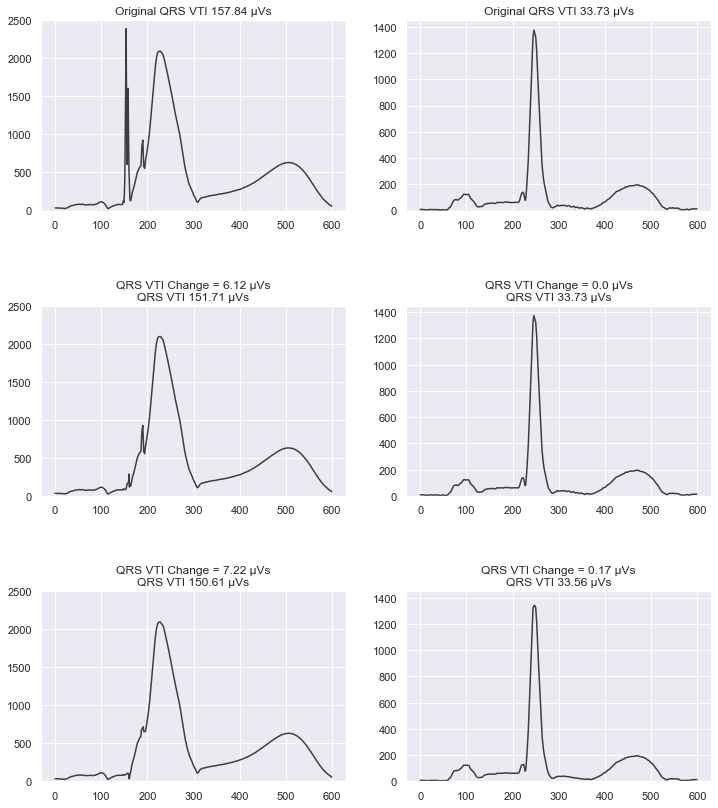

In [29]:
# b = np.arange(0,52,1)
# x = df.x[int(df.iloc[0,35]):int(df.iloc[0,38])]
# y = df.y[int(df.iloc[0,35]):int(df.iloc[0,38])]
# z = df.z[int(df.iloc[0,35]):int(df.iloc[0,38])]
n = 22

fig, ((ax4, ax5), (ax3, ax2), (ax, ax1)) = plt.subplots(3, 2, figsize=(12, 14))

ax4.plot(dfs.Unfiltered_total_xyz[n*1200+350:(n+1)*1200-250].reset_index(drop=True), color='#3d3d3d')
# ax4.plot(dfs.total_xyz[n*1200:(n+1)*1200].reset_index(drop=True), color='#fa3c3c')
ax4.set_title('Original QRS VTI {} µVs'.format(((dfs.Unfiltered_QRSVTI[n*1200]/1000).round(decimals=2))))
ax4.set_ylim(0, 2500)

# ax.plot(dfs.Unfiltered_total_xyz[n*1200:(n+1)*1200].reset_index(drop=True), color='#347deb')
ax.plot(dfs.total_xyz[n*1200+350:(n+1)*1200-250].reset_index(drop=True), color='#3d3d3d')
ax.set_title('QRS VTI Change = {} µVs\nQRS VTI {} µVs'.format(((dfs.Unfiltered_QRSVTI[n*1200]-dfs.QRSVTI[n*1200])/1000).round(decimals=2),((dfs.QRSVTI[n*1200])/1000).round(decimals=2)))
ax.set_ylim(0, 2500)

# ax3.plot(dfs.Unfiltered_total_xyz[n*1200:(n+1)*1200].reset_index(drop=True), color='#347deb')
ax3.plot(dff.total_xyz[n*1200+350:(n+1)*1200-250].reset_index(drop=True), color='#3d3d3d')
ax3.set_title('QRS VTI Change = {} µVs\nQRS VTI {} µVs'.format(((dfs.Unfiltered_QRSVTI[n*1200]-dff.QRSVTI[n*1200])/1000).round(decimals=2),((dff.QRSVTI[n*1200])/1000).round(decimals=2)))
ax3.set_ylim(0, 2500)

n = 107

ax5.plot(dfs.Unfiltered_total_xyz[n*1200+300:(n+1)*1200-300].reset_index(drop=True), color='#3d3d3d')
# ax5.plot(dff.total_xyz[n*1200:(n+1)*1200].reset_index(drop=True), color='#fa3c3c')
ax5.set_title('Original QRS VTI {} µVs'.format((dfs.Unfiltered_QRSVTI[n*1200]/1000).round(decimals=2)));
ax5.set_ylim(0, 1450)

# ax1.plot(dfs.Unfiltered_total_xyz[n*1200:(n+1)*1200].reset_index(drop=True), color='#347deb')
ax1.plot(dfs.total_xyz[n*1200+300:(n+1)*1200-300].reset_index(drop=True), color='#3d3d3d')
ax1.set_title('QRS VTI Change = {} µVs\nQRS VTI {} µVs'.format(((dfs.Unfiltered_QRSVTI[n*1200]-dfs.QRSVTI[n*1200])/1000).round(decimals=2),((dfs.QRSVTI[n*1200])/1000).round(decimals=2)))
ax1.set_ylim(0, 1450)

# ax2.plot(dfs.Unfiltered_total_xyz[n*1200:(n+1)*1200].reset_index(drop=True), color='#347deb')
ax2.plot(dff.total_xyz[n*1200+300:(n+1)*1200-300].reset_index(drop=True), color='#3d3d3d')
ax2.set_title('QRS VTI Change = {} µVs\nQRS VTI {} µVs'.format(((dfs.Unfiltered_QRSVTI[n*1200]-dff.QRSVTI[n*1200])/1000).round(decimals=2),((dff.QRSVTI[n*1200])/1000).round(decimals=2)));
ax2.set_ylim(0, 1450)

plt.subplots_adjust(hspace=.5);
# plt.savefig('Abstract.svg', dpi=3600, format='svg');

In [15]:
df = []
for n in range(32):
    d = np.asarray(data.iloc[:,n+1]).reshape(1, 207, 300)
    df.append(d)

In [16]:
df = np.concatenate(df)

In [17]:
df.shape

(32, 207, 300)

In [18]:
m,n,r = df.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),df.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

In [19]:
out_df

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,71.837687,73.087687,74.337687,76.837687,84.337687,84.337687,91.837687,94.337687,96.837687,...,-21.912313,-20.662313,-19.412313,-18.162313,-16.912313,-23.162313,-23.162313,-23.162313,-23.162313,-20.662313
1,0.0,120.601852,125.601852,133.101852,143.101852,148.101852,155.601852,163.101852,168.101852,175.601852,...,-11.898148,-11.898148,-6.898148,-6.898148,-8.148148,-5.648148,-4.398148,-1.898148,3.101852,5.601852
2,0.0,-88.413462,-98.413462,-108.413462,-107.163462,-108.413462,-110.913462,-117.163462,-120.913462,-125.913462,...,-10.913462,-15.913462,-19.663462,-10.913462,-9.663462,-9.663462,-23.413462,-38.413462,-55.913462,-55.913462
3,0.0,-0.194444,-0.194444,4.805556,4.805556,12.305556,12.305556,17.305556,18.555556,17.305556,...,-2.694444,-0.194444,4.805556,7.305556,12.305556,12.305556,8.555556,2.305556,-2.694444,-7.694444
4,0.0,-9.791667,-12.291667,-11.041667,-9.791667,-7.291667,-7.291667,-7.291667,-7.291667,-3.541667,...,5.208333,2.708333,0.208333,-2.291667,-4.791667,-4.791667,-4.791667,-4.791667,-9.791667,-12.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619,31.0,-183.902257,-189.027257,-198.627257,-204.089757,-210.402257,-217.214757,-223.552257,-230.564757,-238.702257,...,-7.277257,-7.014757,-7.714757,-6.977257,-6.302257,-5.227257,-5.939757,-6.714757,-5.464757,-7.102257
6620,31.0,2537.674519,2550.854567,2464.979567,2378.504567,2261.354567,2107.854567,1951.804567,1798.629567,1608.004567,...,2147.679567,1992.629567,1827.629567,1648.704567,1426.729567,1167.604567,897.029567,630.979567,394.079567,196.404808
6621,31.0,12.649475,14.911124,14.786124,11.223624,5.323624,2.236124,-0.113876,0.261124,0.986124,...,-5.138876,-5.013876,-6.113876,-6.626376,-6.438876,-8.901376,-14.426376,-17.913876,-18.013876,-18.088876
6622,31.0,-548.604038,-553.429038,-559.679038,-561.779038,-561.979038,-559.679038,-554.879038,-548.779038,-539.179038,...,-7.254038,-7.854038,-8.004038,-5.091538,-7.604038,-7.729038,-9.554038,-6.654038,-3.229038,0.958462


In [20]:
test = pd.DataFrame()
for n in range(207):
    test = pd.concat([test, out_df.iloc[n::207,:]])

In [21]:
test = test.drop(0,axis=1)

In [22]:
df = pd.DataFrame()
for n in range(16):
    df = pd.concat([df, pd.concat([test[n::32].reset_index(drop=True).T, test[n+16::32].reset_index(drop=True).T]).T])

df.columns = pd.RangeIndex(0,600)

In [23]:
df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,71.837687,73.087687,74.337687,76.837687,84.337687,84.337687,91.837687,94.337687,96.837687,104.337687,...,-7.232143,-7.232143,-8.482143,-10.982143,-10.982143,-9.732143,-9.732143,-8.482143,-8.482143,-8.482143
1,120.601852,125.601852,133.101852,143.101852,148.101852,155.601852,163.101852,168.101852,175.601852,175.601852,...,266.756757,289.256757,296.756757,341.756757,374.256757,414.256757,471.756757,539.256757,604.256757,650.506757
2,-88.413462,-98.413462,-108.413462,-107.163462,-108.413462,-110.913462,-117.163462,-120.913462,-125.913462,-132.163462,...,708.301282,845.801282,948.301282,1013.301282,1035.801282,1053.301282,1053.301282,993.301282,870.801282,725.801282
3,-0.194444,-0.194444,4.805556,4.805556,12.305556,12.305556,17.305556,18.555556,17.305556,9.805556,...,30.422794,31.672794,30.422794,27.922794,25.422794,20.422794,15.422794,10.422794,5.422794,5.422794
4,-9.791667,-12.291667,-11.041667,-9.791667,-7.291667,-7.291667,-7.291667,-7.291667,-3.541667,0.208333,...,10.198864,15.198864,25.198864,30.198864,37.698864,36.448864,36.448864,60.198864,65.198864,67.698864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,-26.967887,-26.967887,-24.992887,-23.392887,-19.167887,-15.617887,-13.392887,-13.117887,-11.217887,-6.342887,...,-7.277257,-7.014757,-7.714757,-6.977257,-6.302257,-5.227257,-5.939757,-6.714757,-5.464757,-7.102257
203,1.462209,-132.295130,-130.095130,-120.545130,-110.585130,-101.955130,-92.135130,-83.325130,-75.445130,-67.315130,...,2147.679567,1992.629567,1827.629567,1648.704567,1426.729567,1167.604567,897.029567,630.979567,394.079567,196.404808
204,29.776997,28.126997,24.526997,34.626997,34.101997,23.451997,14.376997,6.976997,1.501997,2.626997,...,-5.138876,-5.013876,-6.113876,-6.626376,-6.438876,-8.901376,-14.426376,-17.913876,-18.013876,-18.088876
205,-208.382220,-218.582220,-231.407220,-245.332220,-256.282220,-270.332220,-283.282220,-299.207220,-316.957220,-330.132220,...,-7.254038,-7.854038,-8.004038,-5.091538,-7.604038,-7.729038,-9.554038,-6.654038,-3.229038,0.958462


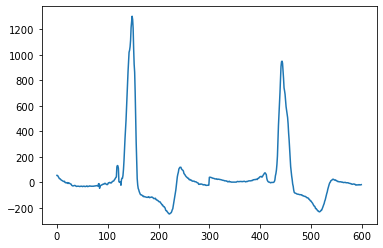

In [24]:
plt.plot(df.iloc[10,:])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.constraints import max_norm
from tensorflow.python.keras import backend as K

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Packages Loaded")


Packages Loaded


In [32]:
inputs = tf.keras.Input(shape=(signal_train.shape[1], signal_train.shape[2]), name='signal')
x = Conv1D(32, 30, activation='relu')(inputs)
x = Conv1D(64, 30, activation='relu')(x)
block_1_output = MaxPooling1D(3)(x)

x = Conv1D(64, 30, activation='relu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_2_output = tf.keras.layers.add([x, block_1_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_3_output = tf.keras.layers.add([x, block_2_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_3_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_4_output = tf.keras.layers.add([x, block_3_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_4_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_5_output = tf.keras.layers.add([x, block_4_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_5_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_6_output = tf.keras.layers.add([x, block_5_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_6_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_7_output = tf.keras.layers.add([x, block_6_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_7_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_8_output = tf.keras.layers.add([x, block_7_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_8_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_9_output = tf.keras.layers.add([x, block_8_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_9_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_10_output = tf.keras.layers.add([x, block_9_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_10_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_11_output = tf.keras.layers.add([x, block_10_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_11_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_12_output = tf.keras.layers.add([x, block_11_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_12_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_13_output = tf.keras.layers.add([x, block_12_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_13_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_14_output = tf.keras.layers.add([x, block_13_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_14_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_15_output = tf.keras.layers.add([x, block_14_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_15_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_16_output = tf.keras.layers.add([x, block_15_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_16_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_17_output = tf.keras.layers.add([x, block_16_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_17_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_18_output = tf.keras.layers.add([x, block_17_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_18_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_19_output = tf.keras.layers.add([x, block_18_output])

x = Conv1D(64, 30, activation='relu', padding='same')(block_19_output)
x = BatchNormalization()(x)
x = Conv1D(64, 30, activation='relu', padding='same')(x)
block_20_output = tf.keras.layers.add([x, block_19_output])

x = Conv1D(64, 30, activation='relu')(block_20_output)
x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(14, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name='resnet')


model.compile(optimizer=Adam(amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=32,
          epochs=40,
         validation_data=(x_test, y_test))

Train on 1085 samples, validate on 535 samples
Epoch 1/40
1085/1085 [==============================] - 14s 13ms/sample - loss: 6.2313 - accuracy: 0.1060 - val_loss: 2.6151 - val_accuracy: 0.0879
Epoch 2/40
1085/1085 [==============================] - 3s 3ms/sample - loss: 2.4724 - accuracy: 0.1272 - val_loss: 2.5014 - val_accuracy: 0.1458
Epoch 3/40
1085/1085 [==============================] - 3s 3ms/sample - loss: 2.4076 - accuracy: 0.1253 - val_loss: 2.4607 - val_accuracy: 0.1421
Epoch 4/40
1085/1085 [==============================] - 3s 3ms/sample - loss: 2.3895 - accuracy: 0.1161 - val_loss: 2.3967 - val_accuracy: 0.1364
Epoch 5/40
1085/1085 [==============================] - 3s 3ms/sample - loss: 2.3627 - accuracy: 0.1539 - val_loss: 2.3606 - val_accuracy: 0.1495
Epoch 6/40
1085/1085 [==============================] - 3s 3ms/sample - loss: 2.3330 - accuracy: 0.1677 - val_loss: 2.3355 - val_accuracy: 0.1626
Epoch 7/40
1085/1085 [==============================] - 3s 3ms/sample - los

In [12]:
def res_block(inputs, layer_size, activation, dropout):
    
    x = Dense(layer_size)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    x = Dense(layer_size)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    x = Dense(layer_size)(x)
    output = tf.keras.layers.add([x, inputs])
    
    return output
    
layer_size = 1024
activation = 'relu'
dropout = .4

inputs = tf.keras.Input(shape=(32, 64), name='img')
x = Dense(layer_size, activation=activation)(inputs)
x = Dense(layer_size, activation=activation)(x)

x = res_block(x, layer_size, activation, dropout)
x = res_block(x, layer_size, activation, dropout)
x = res_block(x, layer_size, activation, dropout)
x = res_block(x, layer_size, activation, dropout)

x = Dense(layer_size, activation=activation)(x)
x = Dropout(0.5)(x)
output1 = Dense(1, activation='linear', name='Pon')(x)
output2 = Dense(1, activation='linear', name='Poff')(x)
output3 = Dense(1, activation='linear', name='Qon')(x)
output4 = Dense(1, activation='linear', name='Qoff')(x)
output5 = Dense(1, activation='linear', name='Ton')(x)
output6 = Dense(1, activation='linear', name='Toff')(x)

model = tf.keras.Model(inputs, [output1, output2, output3, output4, output5, output6], name='resnet')

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)

adam = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True
)


model.compile(loss=["mae", "mae", "mae", "mae", "mae", "mae"], optimizer=adam)
model.summary()
model.fit(x_train, [y_train.iloc[:,0], y_train.iloc[:,1], y_train.iloc[:,2], y_train.iloc[:,3], y_train.iloc[:,4], y_train.iloc[:,5]], epochs=200, batch_size=64, 
          validation_data=(x_test, [y_test.iloc[:,0].values, y_test.iloc[:,1].values, y_test.iloc[:,2].values, y_test.iloc[:,3].values, y_test.iloc[:,4].values, y_test.iloc[:,5].values]))

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 64)]     0                                            
__________________________________________________________________________________________________
dense_135 (Dense)               (None, 32, 1024)     66560       img[0][0]                        
__________________________________________________________________________________________________
dense_136 (Dense)               (None, 32, 1024)     1049600     dense_135[0][0]                  
__________________________________________________________________________________________________
dense_137 (Dense)               (None, 32, 1024)     1049600     dense_136[0][0]                  
_____________________________________________________________________________________________

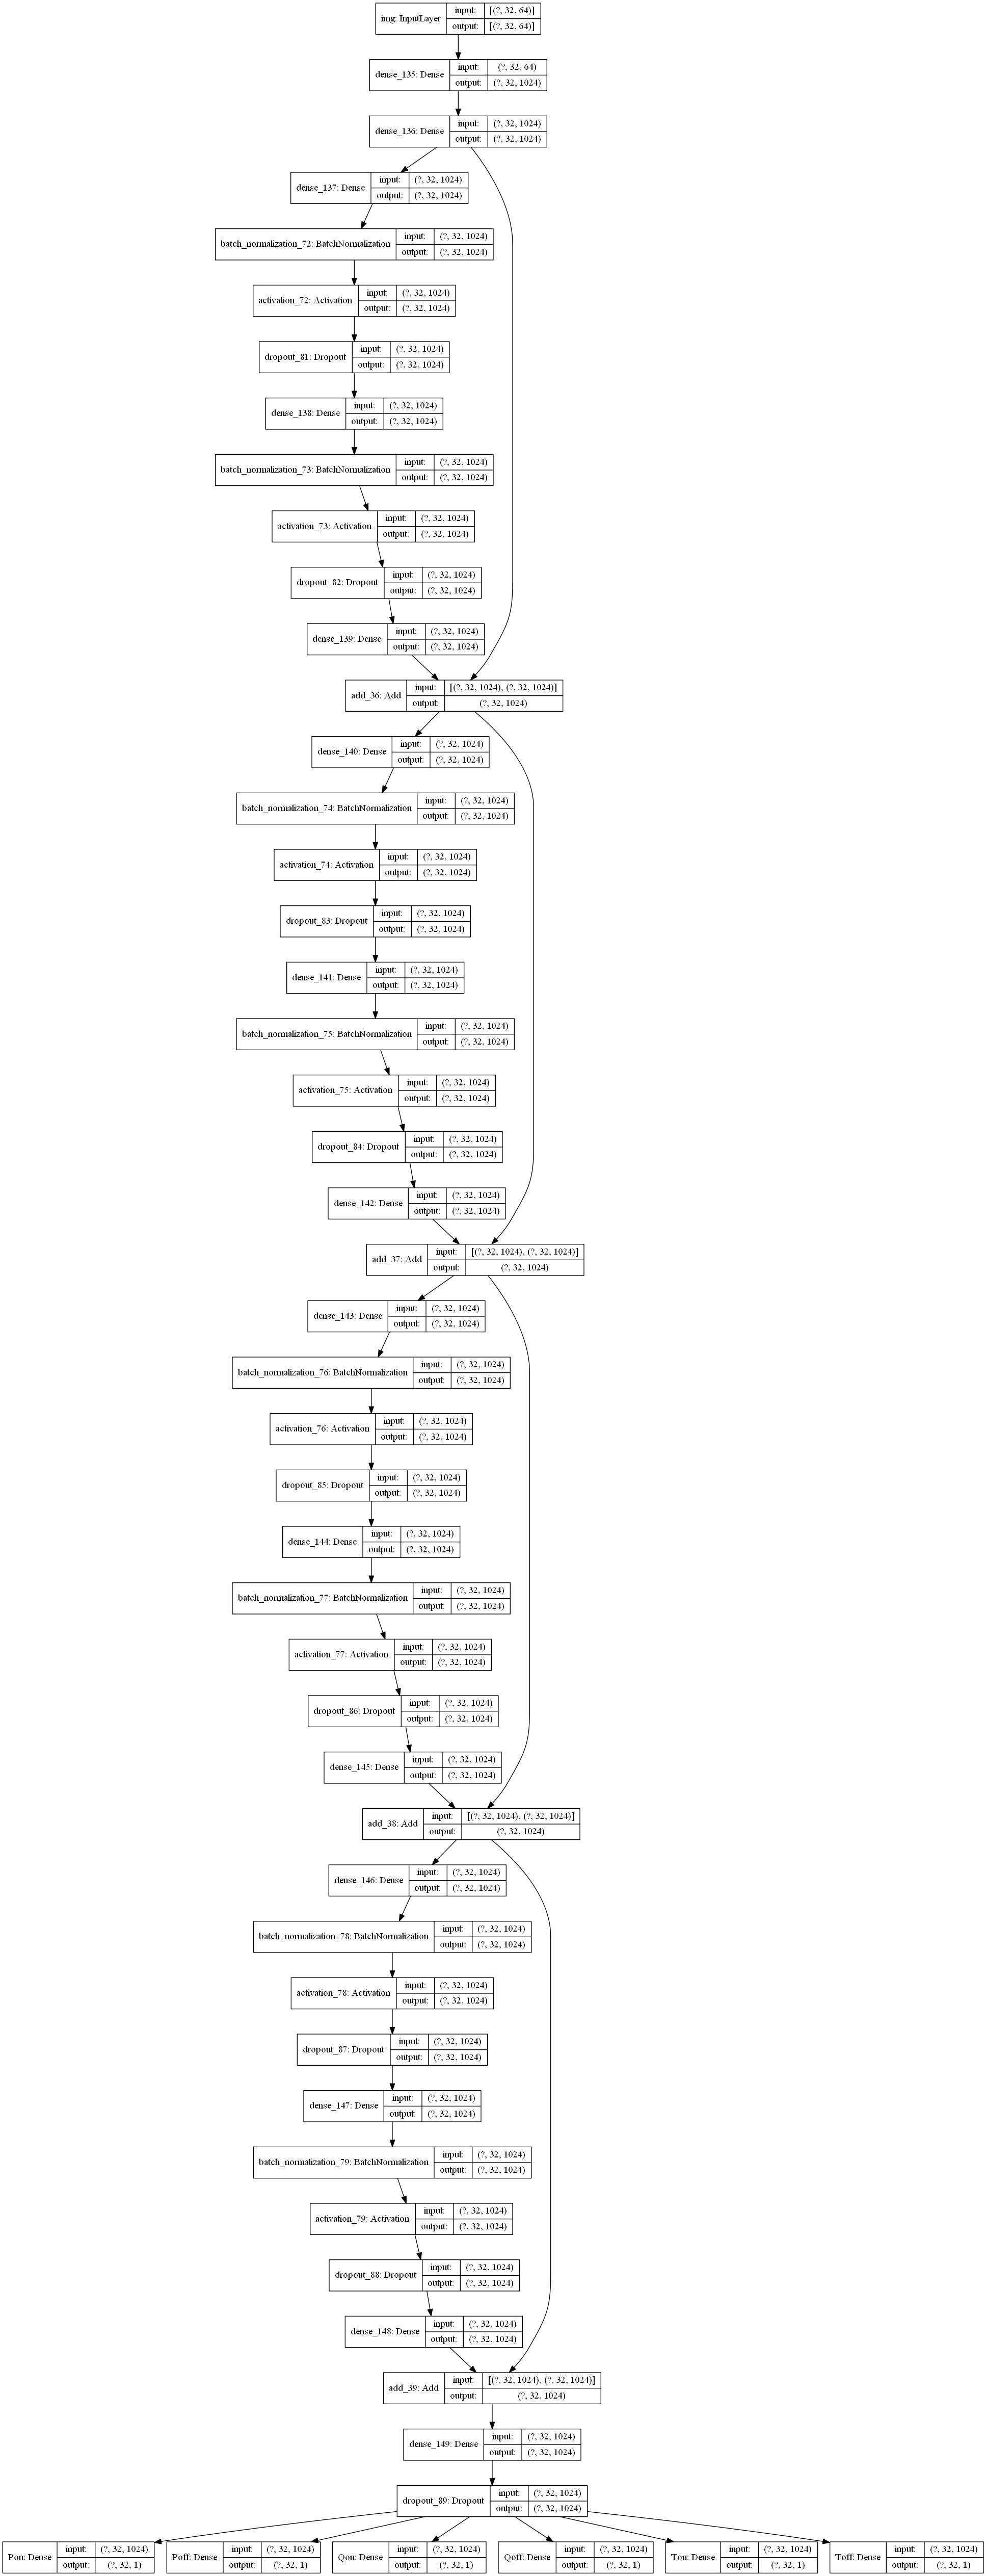

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [154]:
# XCEPTION With Dense ResNet Processing Head

def res_block(inputs, layer_size, activation, dropout):
    
    x = Dense(layer_size)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    x = Dense(layer_size)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    x = Dense(layer_size)(x)
    output = tf.keras.layers.add([x, inputs])
    
    return output
    
layer_size = 512
activation = 'tanh'
dropout = .4

def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size=1,strides=2)
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)
    tensor = conv_bn(tensor, filters=256, kernel_size=1,strides=2)
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)
    tensor = conv_bn(tensor, filters=728, kernel_size=1,strides=2)
    x = Add()([tensor, x])
    
    return x
    

def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        tensor = Add()([tensor, x])
        
    return tensor

def exit_flow(tensor, output):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)
    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    x = sep_bn(x, filters=1535, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool1D()(x)
    x = Dense(units=512, activation='tanh')(x)
    x = res_block(x, layer_size, activation, dropout)
    x = res_block(x, layer_size, activation, dropout)
    x = Dense(units=output, activation='softmax')(x)
    
    return x
    
input_shape = (train_x.shape[1], train_x.shape[2])
input = Input(shape=input_shape)
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x, 3)

from tensorflow.keras import Model
model = Model(inputs=input, outputs=output)

class_weight = {0: 50.,
                1: 50.,
                2: 1.}

model.compile(loss=['categorical_crossentropy'], optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"),
    metrics=['accuracy'])

model.fit(train_x, np.asarray(train_y).astype(np.float32), epochs=200, batch_size=32, class_weight=class_weight, validation_data=(test_x, np.asarray(test_y).astype(np.float32)))

Epoch 1/200
69/69 [==============================] - 9s 125ms/step - loss: 1.2291 - accuracy: 0.6572 - val_loss: 1.0400 - val_accuracy: 0.1322
Epoch 2/200
69/69 [==============================] - 7s 103ms/step - loss: 1.0199 - accuracy: 0.6798 - val_loss: 0.8140 - val_accuracy: 0.7609
Epoch 3/200
69/69 [==============================] - 7s 103ms/step - loss: 1.0618 - accuracy: 0.6730 - val_loss: 0.8680 - val_accuracy: 0.7609
Epoch 4/200
69/69 [==============================] - 8s 109ms/step - loss: 0.9303 - accuracy: 0.6943 - val_loss: 0.7314 - val_accuracy: 0.7609
Epoch 5/200
69/69 [==============================] - 8s 110ms/step - loss: 0.8795 - accuracy: 0.7133 - val_loss: 0.7719 - val_accuracy: 0.7609
Epoch 6/200
69/69 [==============================] - 8s 111ms/step - loss: 0.8135 - accuracy: 0.7233 - val_loss: 0.7247 - val_accuracy: 0.7609
Epoch 7/200
69/69 [==============================] - 8s 114ms/step - loss: 0.7935 - accuracy: 0.7396 - val_loss: 1.0365 - val_accuracy: 0.2681

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16, 32)       3072        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 16, 32)       128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 32)       0           batch_normalization_80[0][0]     
_______________________________________________________________________________________

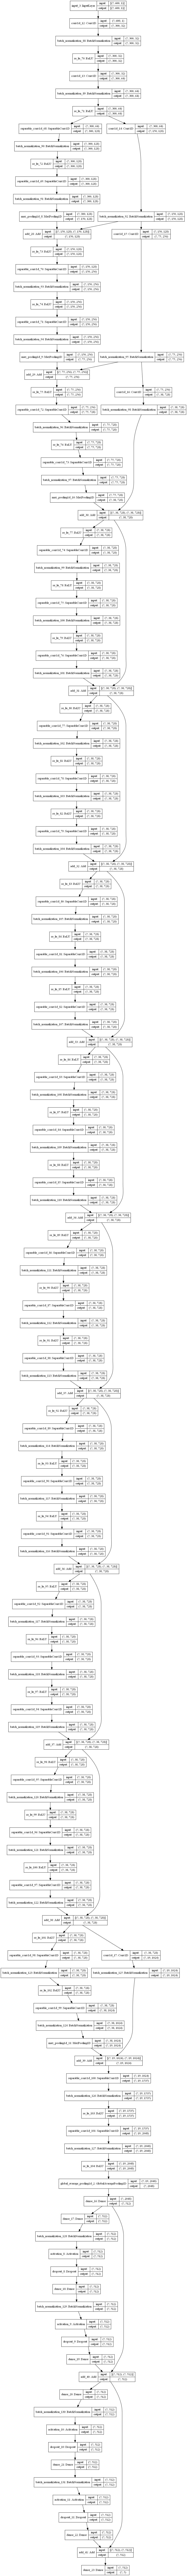

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)